<a href="https://colab.research.google.com/github/dgoldblum/LSTM-Volatility-Prediction/blob/main/ACF_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Porject Folder
Here is the link to the folder that includes the powerpoint and video presentation:
https://drive.google.com/drive/folders/1nPg8syZM7ClCUgFYuLOnKKA_KhfGgeTQ?usp=drive_link

# Data Generation

In [ ]:
!pip install yfinance
!pip install beautifulsoup4
!pip install requests
!pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 5.9 MB/s eta 0:00:00


In [ ]:
import yfinance as yf
import pandas as pd
import bs4 as bs
import requests
import datetime
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

In [ ]:
start_date = '2000-01-01'
end_date = '2022-12-31'
raw_data = yf.download('^RUI', start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


#Feature Engineering

In [ ]:
raw_data.drop(['Volume'], axis = 1, inplace = True)
raw_data['Returns'] = raw_data.Close - raw_data.Close.shift(1)
raw_data['Returns_SQ'] =  np.square(raw_data['Returns'])
raw_data['Log_Returns'] = np.log(raw_data.Close) - np.log(raw_data.Close.shift(1))
raw_data['PCT_Change'] = ((raw_data.Close - raw_data.Close.shift(1))/raw_data.Close.shift(1))*100
raw_data['Log_Trading_Range'] = np.log(raw_data.High) - np.log(raw_data.Low)
raw_data['Vol30'] = raw_data['Log_Returns'].rolling(window = 30).std()
raw_data['Vol60'] = raw_data['Log_Returns'].rolling(window = 60).std()
raw_data['ROC'] = ((raw_data.Close - raw_data.Close.shift(10)) / raw_data.Close.shift(10)) * 100
raw_data['Var30'] = raw_data.Close.rolling(window = 30).var()
raw_data['Var60'] = raw_data.Close.rolling(window = 60).var()
raw_data.dropna(axis = 0, inplace = True)

In [ ]:
raw_data

,Open,High,Low,Close,Adj Close,Returns,Returns_SQ,Log_Returns,PCT_Change,Log_Trading_Range,Vol30,Vol60,ROC,Var30,Var60
Date,,,,,,,,,,,,,,,
2000-03-29,802.369995,807.530029,794.609985,799.630005,799.630005,-2.739990,7.507546,-0.003421,-0.341487,0.016129,0.016325,0.015617,7.874429,1053.422504,605.698398
2000-03-30,799.630005,805.409973,781.400024,789.030029,789.030029,-10.599976,112.359482,-0.013345,-1.325610,0.030264,0.016456,0.014812,1.435997,1076.145718,621.459946
2000-03-31,789.030029,806.940002,786.530029,797.989990,797.989990,8.959961,80.280900,0.011292,1.135567,0.025618,0.016537,0.014869,2.091753,1115.784736,648.359898
2000-04-03,797.989990,801.520020,790.299988,797.250000,797.250000,-0.739990,0.547586,-0.000928,-0.092732,0.014097,0.015437,0.014871,2.898853,1094.224727,671.843470
2000-04-04,797.250000,807.960022,746.119995,790.450012,790.450012,-6.799988,46.239834,-0.008566,-0.852930,0.079626,0.015593,0.014546,-0.454624,1054.132997,692.735509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,2092.409912,2108.260010,2082.520020,2108.120117,2108.120117,11.910156,141.851822,0.005666,0.568176,0.012284,0.011995,0.016208,-2.277885,1687.903311,5545.258445
2022-12-27,2106.919922,2108.939941,2091.120117,2099.360107,2099.360107,-8.760010,76.737771,-0.004164,-0.415537,0.008486,0.011820,0.016101,-4.079236,1830.487206,5203.132611
2022-12-28,2100.350098,2108.800049,2072.770020,2073.780029,2073.780029,-25.580078,654.340397,-0.012260,-1.218470,0.017233,0.011889,0.015861,-5.951873,2119.447963,5087.080629


#Classic Arch, Garch, and, EGarch Models

Show the different garch models

In [ ]:
from arch import arch_model

In [ ]:
#Train models

#arch
arch = arch_model(raw_data['PCT_Change'], vol='ARCH', p=1, dist='normal')
farch = arch.fit(update_freq=5, disp = 'off')

#Garch
garch = arch_model(raw_data['PCT_Change'], vol='GARCH', p=1, q=1, dist='normal')
fgarch = garch.fit(update_freq=5, disp='off')

#EGarch
egarch = arch_model(raw_data['PCT_Change'], vol='EGARCH', p=1, q=1, dist='normal')
fegarch = egarch.fit(update_freq=5, disp='off')


In [ ]:
#arch data
forecasts_arch = farch.forecast(horizon=10)
vol_arch = farch.conditional_volatility

forecasts_garch = fgarch.forecast(horizon=10, method = 'simulation')
vol_garch = fgarch.conditional_volatility

forecasts_egarch = fegarch.forecast(horizon=10, method = 'simulation')
vol_egarch = fegarch.conditional_volatility

In [ ]:
print('ARCH', forecasts_arch.variance[-1:], '\n\n')
print('GARCH', forecasts_garch.variance[-1:], '\n\n')
print('EGARCH', forecasts_egarch.variance[-1:], '\n\n')

ARCH                 h.01      h.02      h.03      h.04      h.05      h.06  \
Date                                                                     
2022-12-30  1.021262  1.406863  1.567741  1.634861  1.662865  1.674548   

                h.07      h.08      h.09      h.10  
Date                                                
2022-12-30  1.679423  1.681457  1.682305  1.682659   


GARCH               h.01      h.02      h.03      h.04      h.05      h.06  \
Date                                                                   
2022-12-30  1.4261  1.421583  1.425926  1.419369  1.414047  1.417261   

                h.07      h.08      h.09      h.10  
Date                                                
2022-12-30  1.409657  1.416313  1.428712  1.427295   


EGARCH                 h.01      h.02     h.03      h.04      h.05     h.06  \
Date                                                                   
2022-12-30  1.620903  1.631437  1.65169  1.677348  1.685214  1.68284   

 

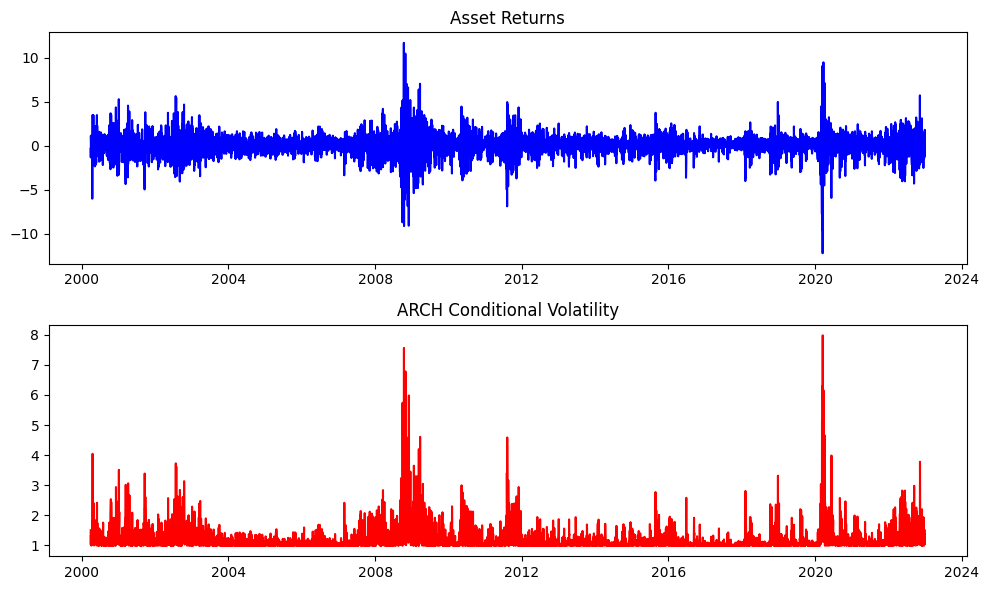

In [ ]:
plt.figure(figsize=(10, 6))

# Plot returns
plt.subplot(2, 1, 1)
plt.plot(raw_data['PCT_Change'], color='blue')
plt.title('Asset Returns')

# Plot conditional volatility
plt.subplot(2, 1, 2)
plt.plot(vol_arch, color='red')
plt.title('ARCH Conditional Volatility')

plt.tight_layout()
plt.show()

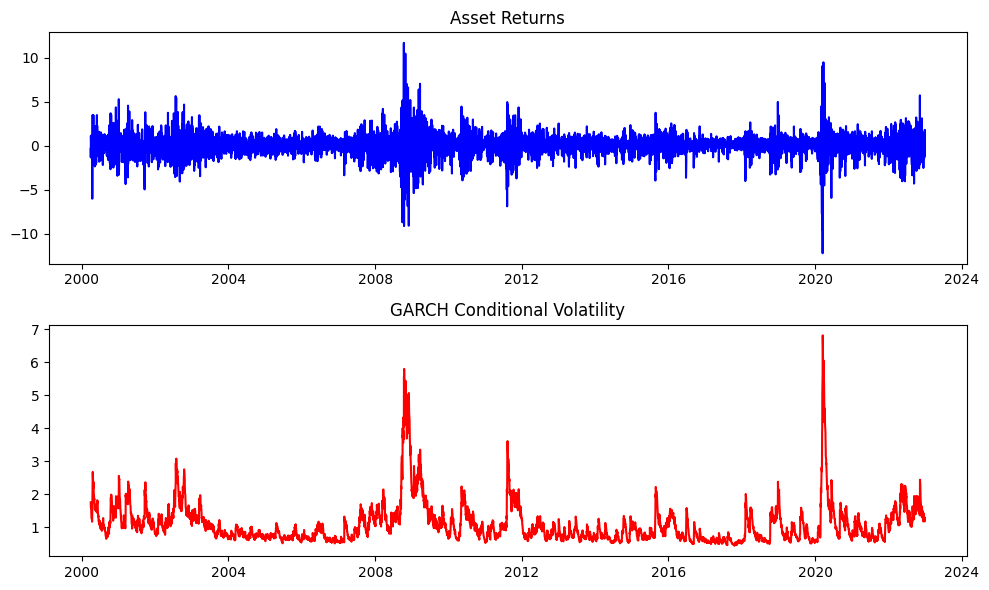

In [ ]:
plt.figure(figsize=(10, 6))

# Plot returns
plt.subplot(2, 1, 1)
plt.plot(raw_data['PCT_Change'], color='blue')
plt.title('Asset Returns')

# Plot conditional volatility
plt.subplot(2, 1, 2)
plt.plot(vol_garch, color='red')
plt.title('GARCH Conditional Volatility')

plt.tight_layout()
plt.show()

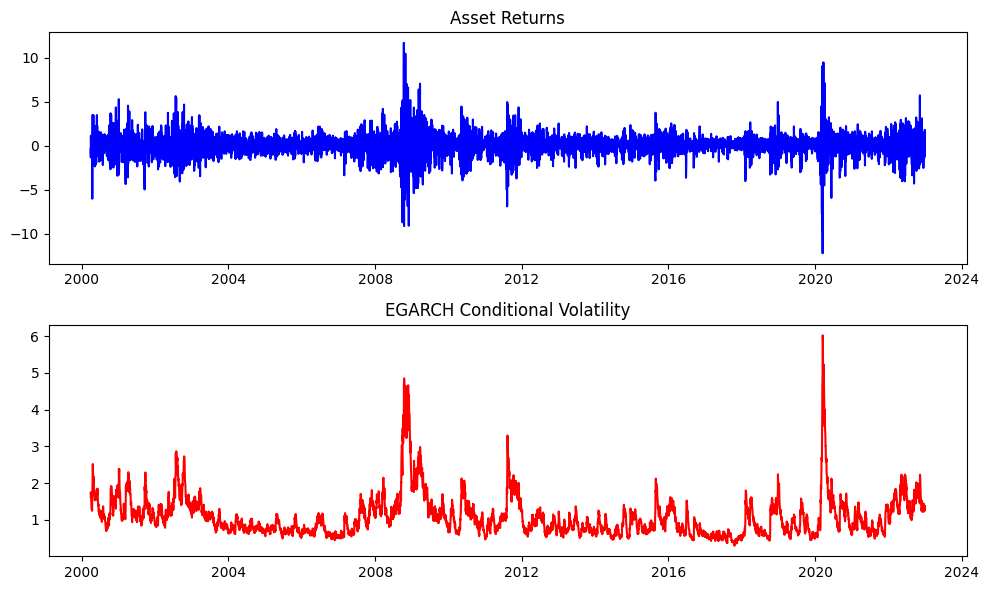

In [ ]:
plt.figure(figsize=(10, 6))

# Plot returns
plt.subplot(2, 1, 1)
plt.plot(raw_data['PCT_Change'], color='blue')
plt.title('Asset Returns')

# Plot conditional volatility
plt.subplot(2, 1, 2)
plt.plot(vol_egarch, color='red')
plt.title('EGARCH Conditional Volatility')

plt.tight_layout()
plt.show()

#LSTM Arch and Garch

Do three different models:
*   Pure LSTM
*   LSTM with GARCH predictions as a feature
* LSTM then GARCH on residuals




In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Activation
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp
from tensorflow.keras.utils import plot_model

In [ ]:
def nnData(raw_data):
  data_norm=(raw_data-raw_data.mean())/(raw_data.max()-raw_data.min())
  data_norm.fillna(0, inplace = True)
  window_size = 20

  data_array = data_norm.values

  X_sequences = []
  y_sequences = []

  # Iterate through the data to create sequences
  for i in range(len(data_array) - window_size):
      X_sequence = data_array[i:i+window_size]  # Input features (past days)
      y_sequence = data_array[i+window_size]    # Target variable (next day)

      X_sequences.append(X_sequence)
      y_sequences.append(y_sequence)

  X_sequences = np.array(X_sequences)
  y_sequences = np.array(y_sequences)

  train_percentage = 0.8

  split_index = int(train_percentage * len(X_sequences))

  X_train = X_sequences[:split_index]
  y_train = y_sequences[:split_index]
  X_test = X_sequences[split_index:]
  y_test = y_sequences[split_index:]
  return X_train, y_train, X_test, y_test


In [ ]:
def createModel(X_train, y_train):
  input_shape = (X_train.shape[1], X_train.shape[2])

  model = Sequential()
  model.add(LSTM(units=32, input_shape=input_shape))
  model.add(Dense(units=64, activation='tanh'))
  model.add(Dense(units=32, activation='tanh'))
  model.add(Dense(units=16, activation='tanh'))
  model.add(Dense(units=8, activation='tanh'))
  model.add(Dense(units=y_train.shape[1]))  # Output layer


  optimizer = Adam(learning_rate=0.001)

  model.compile(optimizer=optimizer, loss='mse')

  return model

Epoch 1/100
37/37 [==============================] - 8s 56ms/step - loss: 0.0072 - val_loss: 0.0063
Epoch 2/100
37/37 [==============================] - 1s 24ms/step - loss: 0.0027 - val_loss: 0.0059
Epoch 3/100
37/37 [==============================] - 1s 31ms/step - loss: 0.0017 - val_loss: 0.0048
Epoch 4/100
37/37 [==============================] - 1s 36ms/step - loss: 0.0013 - val_loss: 0.0040
Epoch 5/100
37/37 [==============================] - 1s 41ms/step - loss: 0.0012 - val_loss: 0.0032
Epoch 6/100
37/37 [==============================] - 1s 32ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 7/100
37/37 [==============================] - 1s 22ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 8/100
37/37 [==============================] - 1s 25ms/step - loss: 0.0010 - val_loss: 0.0016
Epoch 9/100
37/37 [==============================] - 0s 13ms/step - loss: 9.6010e-04 - val_loss: 0.0013
Epoch 10/100
37/37 [==============================] - 0s 13ms/step - loss: 9.2653e-04 - val_loss

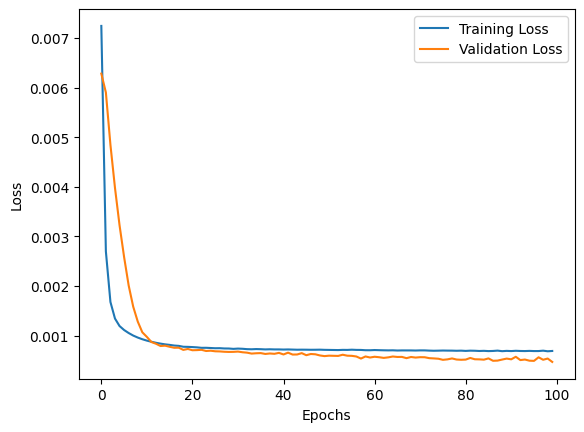

In [ ]:
X_train, y_train, X_test, y_test = nnData(raw_data)
model = createModel(X_train, y_train)

history = model.fit(X_train, y_train, epochs=100, batch_size=100, validation_split=0.2)
loss = model.evaluate(X_test, y_test)

print("Test Loss:", loss)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(X_test)[:, 7]

error_arr = []
for i in range(len(y_pred)):
  error_arr.append(np.square(y_test[i, 7]-y_pred[i]))

mse = np.mean(error_arr)

print(mse)

36/36 [==============================] - 1s 3ms/step
0.0037188293887120277


Epoch 1/100
37/37 [==============================] - 3s 27ms/step - loss: 0.0069 - val_loss: 0.0071
Epoch 2/100
37/37 [==============================] - 0s 13ms/step - loss: 0.0025 - val_loss: 0.0064
Epoch 3/100
37/37 [==============================] - 0s 13ms/step - loss: 0.0015 - val_loss: 0.0051
Epoch 4/100
37/37 [==============================] - 0s 13ms/step - loss: 0.0012 - val_loss: 0.0039
Epoch 5/100
37/37 [==============================] - 0s 13ms/step - loss: 0.0011 - val_loss: 0.0030
Epoch 6/100
37/37 [==============================] - 0s 13ms/step - loss: 0.0010 - val_loss: 0.0023
Epoch 7/100
37/37 [==============================] - 0s 13ms/step - loss: 9.6502e-04 - val_loss: 0.0017
Epoch 8/100
37/37 [==============================] - 0s 13ms/step - loss: 9.2691e-04 - val_loss: 0.0014
Epoch 9/100
37/37 [==============================] - 0s 12ms/step - loss: 8.8417e-04 - val_loss: 0.0011
Epoch 10/100
37/37 [==============================] - 0s 13ms/step - loss: 8.6279e-04 - 

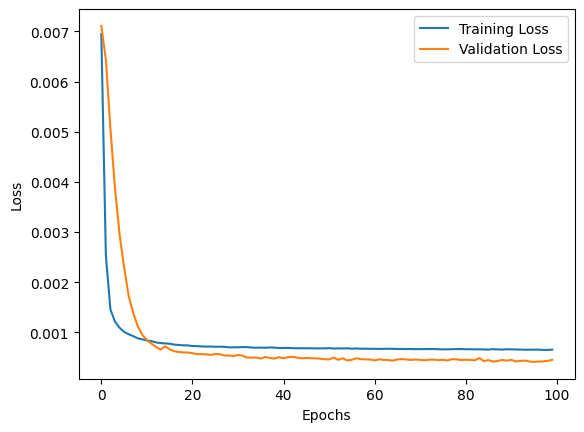

In [ ]:
garch_df = raw_data.copy(deep=True)
garch_df['G_Vol'] = vol_garch

X_train_g, y_train_g, X_test_g, y_test_g = nnData(garch_df)
g_model = createModel(X_train_g, y_train_g)

history_g = g_model.fit(X_train_g, y_train_g, epochs=100, batch_size=100, validation_split=0.2)
loss = g_model.evaluate(X_test_g, y_test_g)

print("Test Loss:", loss)

# Plot training and validation loss
plt.plot(history_g.history['loss'], label='Training Loss')
plt.plot(history_g.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Doing GARCH on the predicted returns of models A and B

In [ ]:
y_pred = model.predict(X_test)
y_pred_g = g_model.predict(X_test_g)


pred_garch_t = arch_model(y_test[:, 5]*100, vol='GARCH', p=1, q=1, dist='normal')
fgarch_t = pred_garch_t.fit(update_freq=5, disp='off')

pred_garch_a = arch_model(y_pred[:, 5]*100, vol='GARCH', p=1, q=1, dist='normal')
fgarch_a = pred_garch_a.fit(update_freq=5, disp='off')

pred_garch_b = arch_model(y_pred_g[:, 5]*100, vol='GARCH', p=1, q=1, dist='normal')
fgarch_b = pred_garch_a.fit(update_freq=5, disp='off')

forecasts_garch_t = fgarch_t.forecast(horizon=10)
vol_garch_t = fgarch_t.conditional_volatility

forecasts_garch_a = fgarch_a.forecast(horizon=10)
vol_garch_a = fgarch_a.conditional_volatility

forecasts_garch_b = fgarch_b.forecast(horizon=10)
vol_garch_b = fgarch_b.conditional_volatility

36/36 [==============================] - 1s 3ms/step


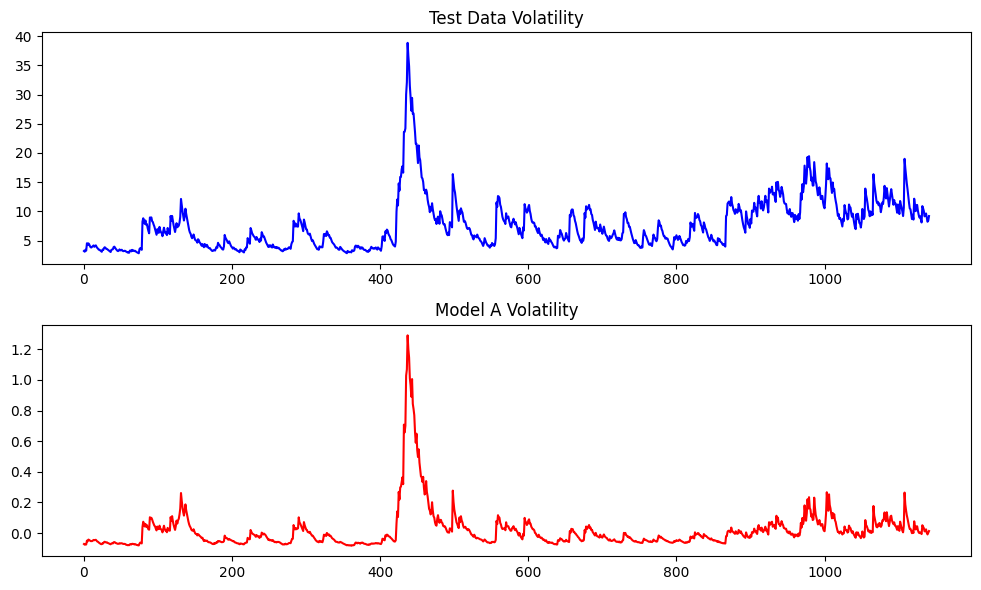

In [ ]:
plt.figure(figsize=(10, 6))

# Plot returns
plt.subplot(2, 1, 1)
plt.plot(vol_garch_t, color='blue')
plt.title('Test Data Volatility')

# Plot conditional volatility
plt.subplot(2, 1, 2)
plt.plot(y_pred_g[:, 15], color='red')
plt.title('Model A Volatility')


plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test_g[:, 3], y_pred_g[:, 3], squared = False)

0.13470698713346904

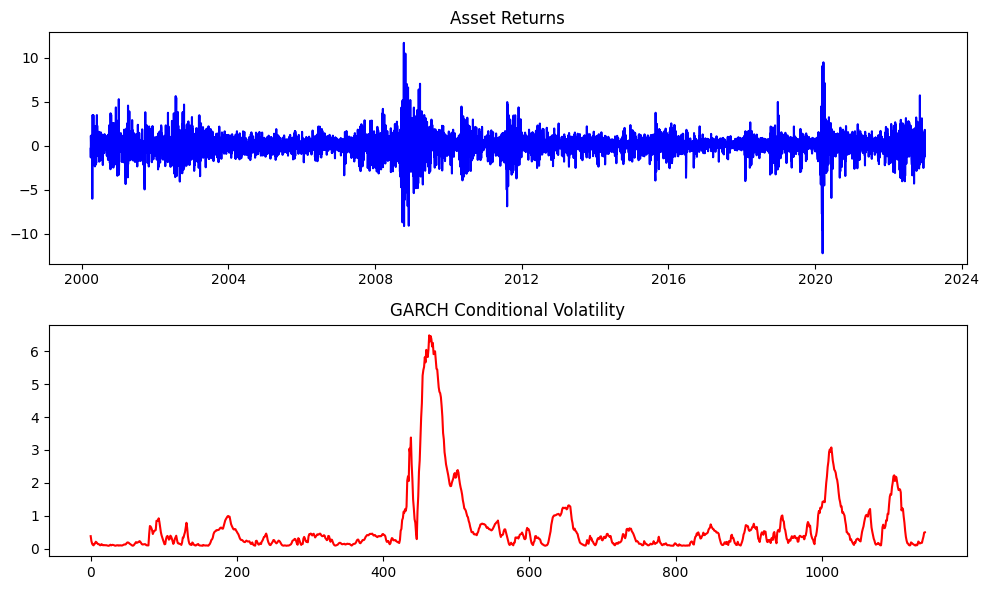

In [ ]:
plt.figure(figsize=(10, 6))

# Plot returns
plt.subplot(2, 1, 1)
plt.plot(raw_data['PCT_Change'], color='blue')
plt.title('Asset Returns')

# Plot conditional volatility
plt.subplot(2, 1, 2)
plt.plot(vol_garch_b, color='red')
plt.title('GARCH Conditional Volatility')

plt.tight_layout()
plt.show()

#Graphing

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot((raw_data.index[-len(y_test):]), y_test[:,3], color='black', label='Actual Stock Price', alpha = .5)
plt.plot((raw_data.index[-len(y_test):]), y_pred[:, 3], color='red', label='Predicted Stock Price: Model A', alpha = .5)
plt.plot((raw_data.index[-len(y_test):]), y_pred_g[:, 3], color='blue', label='Predicted Stock Price: Model B', alpha = .5)
plt.title('Actual vs Predicted Russell 1000 Prices')
plt.xlabel('Time (scaled)')
plt.ylabel('Price')
plt.legend()
plt.show()


<ipython-input-23-be3979e4dae5>:16: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  forecast_dates = pd.date_range(start=last_date, periods=len(out_of_sample_volatilities), closed='left')


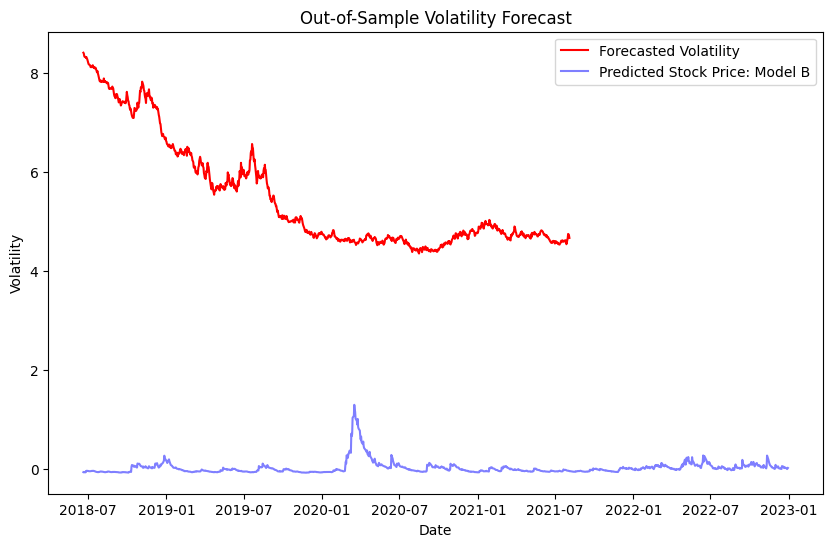

In [ ]:

data_norm=(raw_data-raw_data.mean())/(raw_data.max()-raw_data.min())
data_norm.fillna(0, inplace = True)

garch = arch_model(data_norm['Returns']*100, vol='GARCH', p=1, q=1, dist='normal')
fgarch = garch.fit(update_freq=5, disp='off')

forecasts_garch = fgarch.forecast(horizon=len(y_test), method = 'simulation')
vol_garch = fgarch.conditional_volatility


# Extract forecasted variances and compute volatilities
out_of_sample_volatilities = np.sqrt(forecasts_garch.variance.dropna().values[-1])

# Create a date range for the forecast period
last_date = raw_data.index[-len(y_test)]
forecast_dates = pd.date_range(start=last_date, periods=len(out_of_sample_volatilities), closed='left')

# Plot the out-of-sample volatilities
plt.figure(figsize=(10, 6))
plt.plot(forecast_dates, out_of_sample_volatilities, color='red', label='Forecasted Volatility')
plt.plot((raw_data.index[-len(y_test):]), y_pred_g[:, 15], color='blue', label='Predicted Stock Price: Model B', alpha = .5)
plt.title('Out-of-Sample Volatility Forecast')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

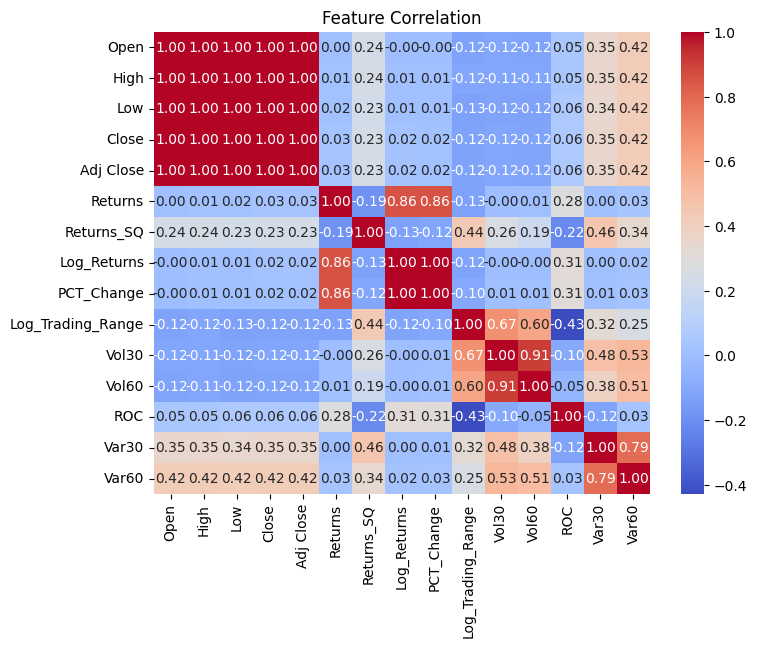

In [ ]:
import seaborn as sns

corr = raw_data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation')
plt.show()

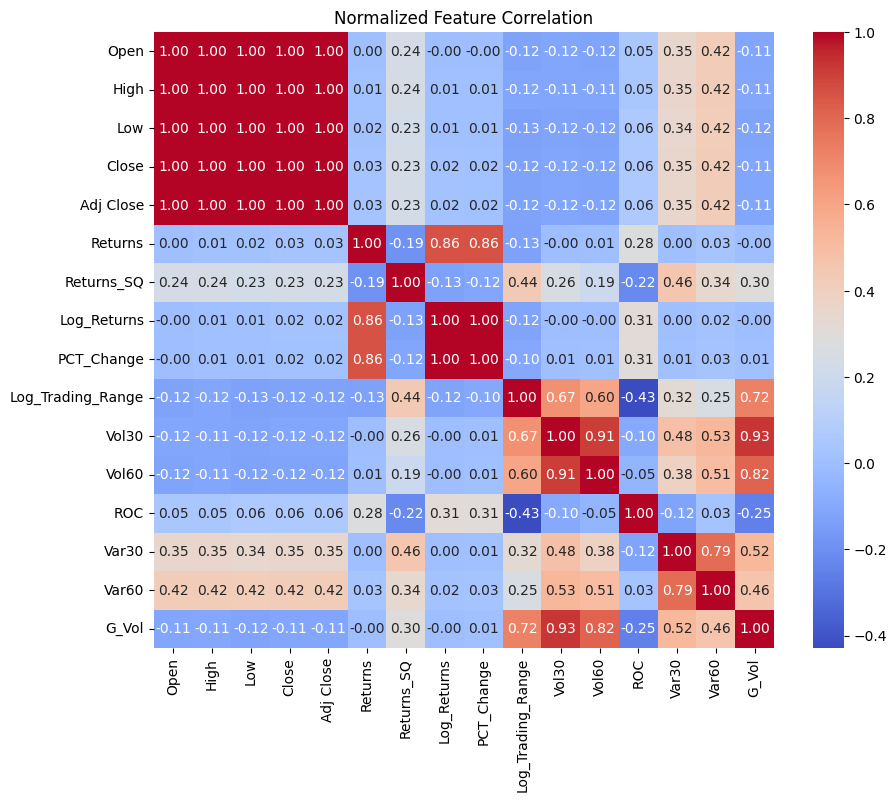

In [ ]:
data_norm=(garch_df-garch_df.mean())/(garch_df.max()-garch_df.min())
data_norm.fillna(0, inplace = True)

corr_norm = data_norm.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_norm, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Normalized Feature Correlation')
plt.show()

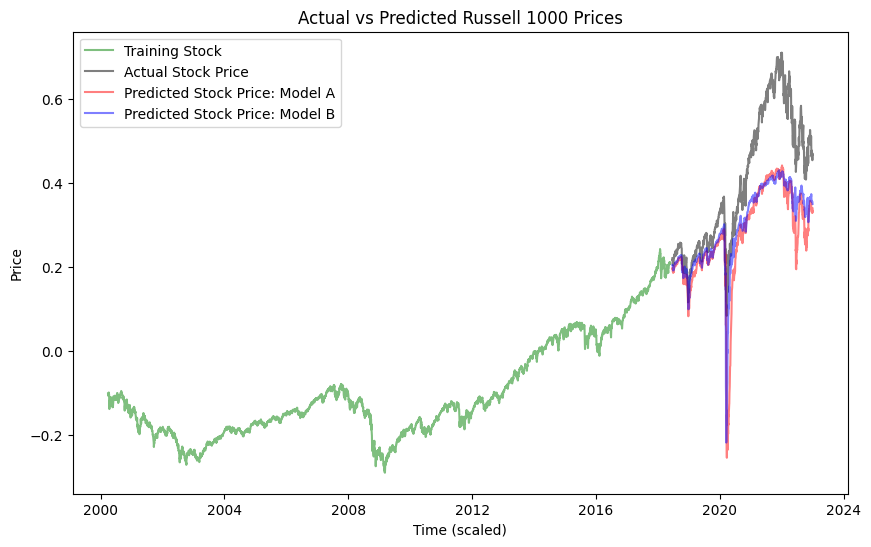

In [ ]:



plt.figure(figsize=(10, 6))
plt.plot((raw_data.index[:len(X_train)]), X_train[:, 0 ,3], color='green', label='Training Stock', alpha = .5)
plt.plot((raw_data.index[-len(y_test):]), y_test[:,3], color='black', label='Actual Stock Price', alpha = .5)
plt.plot((raw_data.index[-len(y_test):]), y_pred[:, 3], color='red', label='Predicted Stock Price: Model A', alpha = .5)
plt.plot((raw_data.index[-len(y_test):]), y_pred_g[:, 3], color='blue', label='Predicted Stock Price: Model B', alpha = .5)
plt.title('Actual vs Predicted Russell 1000 Prices')
plt.xlabel('Time (scaled)')
plt.ylabel('Price')
plt.legend()
plt.show()


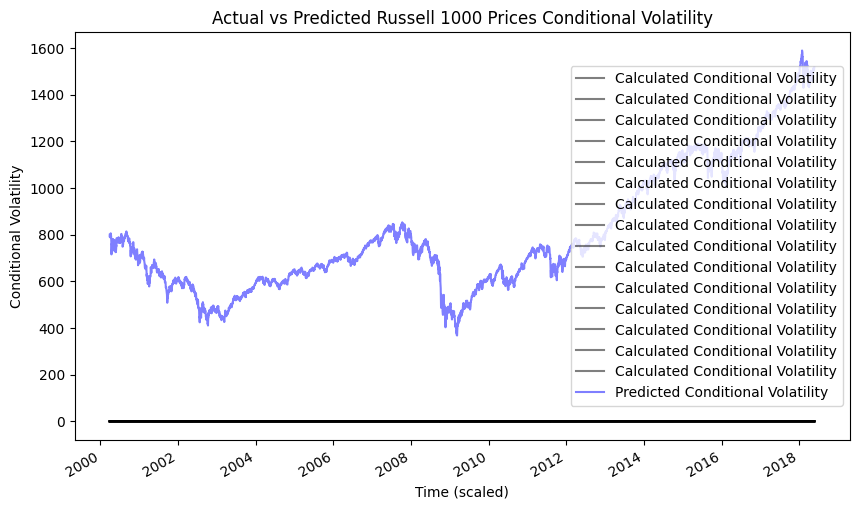

In [ ]:
train_percentage = 0.8

plt.figure(figsize=(10, 6))
plt.plot((raw_data.index[:len(X_train)]), X_train[:,3], color='black', label='Calculated Conditional Volatility', alpha = .5)
plt.plot((raw_data.index[:len(X_train)]), raw_data.loc[raw_data.index[:len(X_train)], 'Close'], color='blue', label='Predicted Conditional Volatility', alpha = .5)
plt.title('Actual vs Predicted Russell 1000 Prices Conditional Volatility')
plt.xlabel('Time (scaled)')
plt.ylabel('Conditional Volatility')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

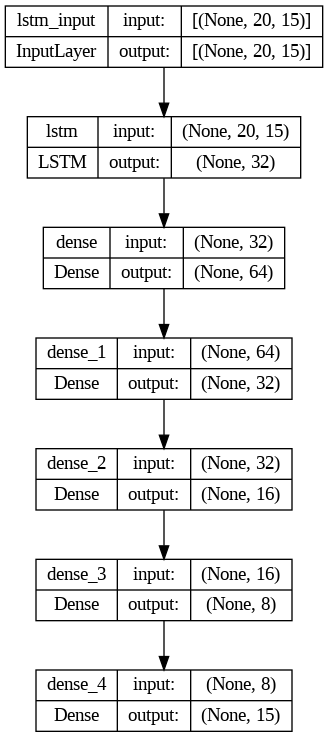

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
garch_df.head()

,Open,High,Low,Close,Adj Close,Returns,Returns_SQ,Log_Returns,PCT_Change,Log_Trading_Range,Vol30,Vol60,ROC,Var30,Var60,G_Vol
Date,,,,,,,,,,,,,,,,
2000-03-29,802.369995,807.530029,794.609985,799.630005,799.630005,-2.739990,7.507546,-0.003421,-0.341487,0.016129,0.016325,0.015617,7.874429,1053.422504,605.698398,1.750390
2000-03-30,799.630005,805.409973,781.400024,789.030029,789.030029,-10.599976,112.359482,-0.013345,-1.325610,0.030264,0.016456,0.014812,1.435997,1076.145718,621.459946,1.636024
2000-03-31,789.030029,806.940002,786.530029,797.989990,797.989990,8.959961,80.280900,0.011292,1.135567,0.025618,0.016537,0.014869,2.091753,1115.784736,648.359898,1.601809
2000-04-03,797.989990,801.520020,790.299988,797.250000,797.250000,-0.739990,0.547586,-0.000928,-0.092732,0.014097,0.015437,0.014871,2.898853,1094.224727,671.843470,1.540104
2000-04-04,797.250000,807.960022,746.119995,790.450012,790.450012,-6.799988,46.239834,-0.008566,-0.852930,0.079626,0.015593,0.014546,-0.454624,1054.132997,692.735509,1.436774


<Figure size 1000x600 with 0 Axes>

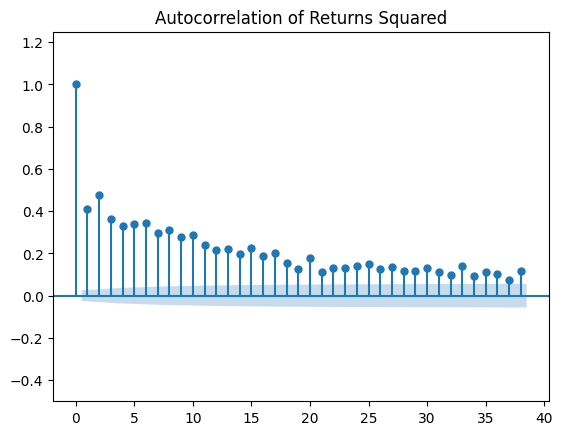

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(10, 6))
plot_acf(raw_data['Returns_SQ'], alpha=0.05)
plt.title('Autocorrelation of Returns Squared')
plt.ylim(-.5, 1.25)
plt.show()

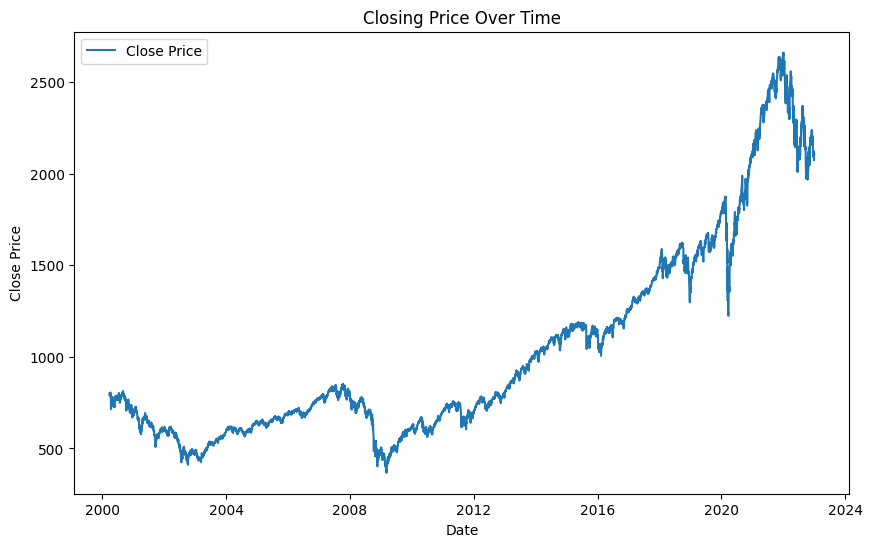

In [ ]:
#Closing Prices


plt.figure(figsize=(10, 6))
plt.plot(raw_data.index, raw_data['Close'], label='Close Price')
plt.title('Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


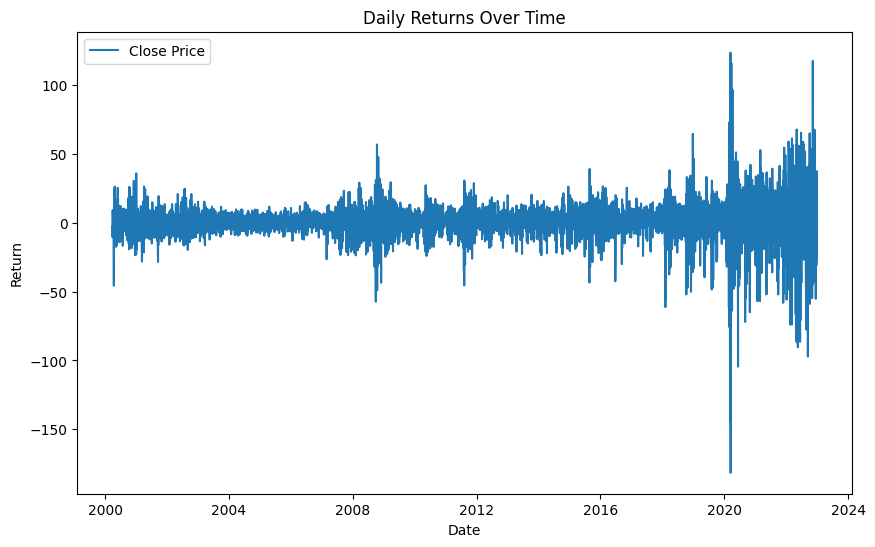

In [ ]:
#Closing Prices


plt.figure(figsize=(10, 6))
plt.plot(raw_data.index, raw_data['Returns'], label='Close Price')
plt.title('Daily Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.show()


In [ ]:
#Candle Stick Plot
import plotly.graph_objects as go


fig = go.Figure(data=[go.Candlestick(x=raw_data.index,
                open=raw_data['Open'],
                high=raw_data['High'],
                low=raw_data['Low'],
                close=raw_data['Close'])])

fig.update_layout(title='Candlestick Chart', xaxis_title='Date', yaxis_title='Price')
fig.show()


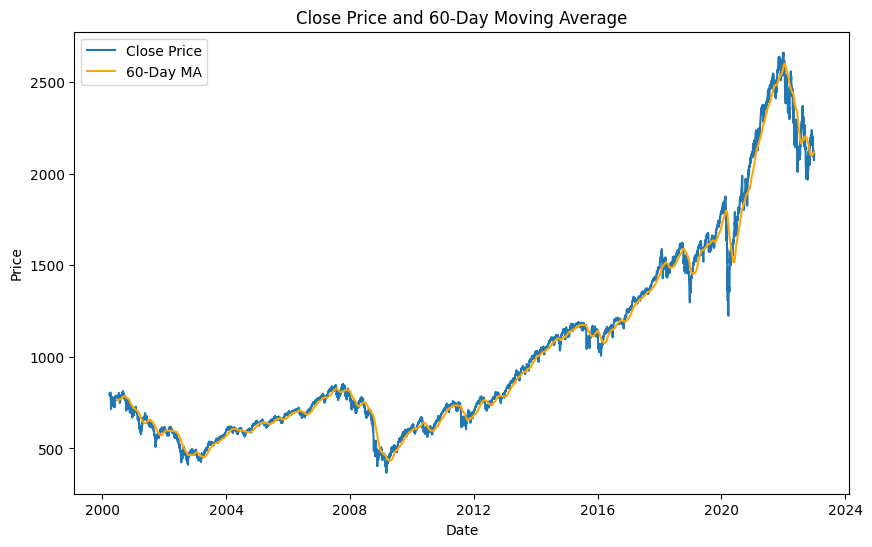

In [ ]:
graph_data = raw_data
graph_data['MA60'] = raw_data['Close'].rolling(window=60).mean()

plt.figure(figsize=(10, 6))
plt.plot(graph_data.index, graph_data['Close'], label='Close Price')
plt.plot(graph_data.index, graph_data['MA60'], label='60-Day MA', color='orange')
plt.title('Close Price and 60-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
raw_data['Returns'].mean()

0.2276510491139648

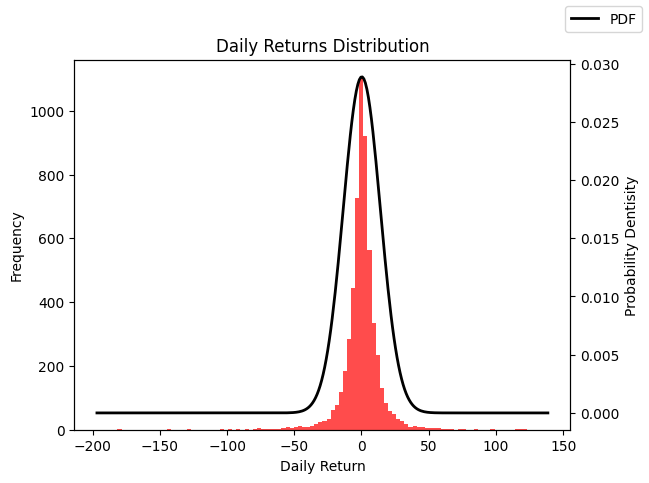

In [ ]:
from scipy.stats import norm

fig, ax1 = plt.subplots()
ax1.set_xlabel('Daily Return')
ax1.set_ylabel('Frequency')

plt.hist(raw_data['Returns'].dropna(), bins=100, color='red', alpha=0.7)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 300)

ax2 = ax1.twinx()
ax2.set_ylabel('Probability Dentisity')

p = norm.pdf(x, raw_data['Returns'].mean(), raw_data['Returns'].std())

plt.plot(x, p, 'k', linewidth=2, label='PDF')

ax2.tick_params(axis = 'y')
ax2.ticklabel_format(useOffset=False)

plt.title('Daily Returns Distribution')

fig.legend()

plt.show()


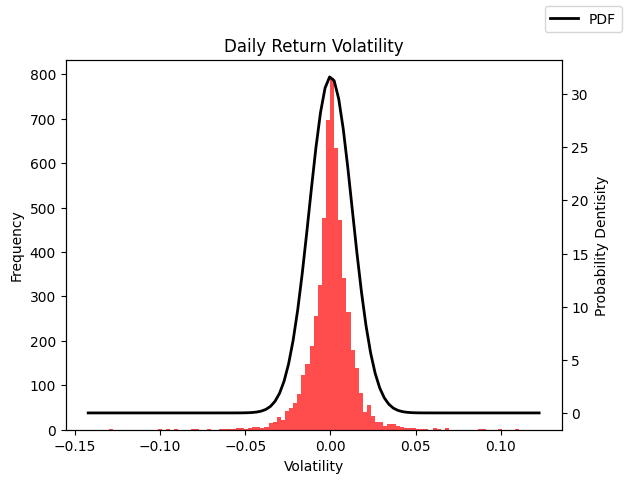

In [ ]:
from scipy.stats import norm

fig, ax1 = plt.subplots()
ax1.set_xlabel('Volatility')
ax1.set_ylabel('Frequency')

plt.hist(raw_data['Log_Returns'].dropna(), bins=100, color='red', alpha=0.7)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)

ax2 = ax1.twinx()
ax2.set_ylabel('Probability Dentisity')

p = norm.pdf(x, raw_data['Log_Returns'].mean(), raw_data['Log_Returns'].std())

plt.plot(x, p, 'k', linewidth=2, label='PDF')

ax2.tick_params(axis = 'y')
ax2.ticklabel_format(useOffset=False)

plt.title('Daily Return Volatility')

fig.legend()
plt.show()


Text(0.5, 1.0, 'GARCH Conditional Volatility')

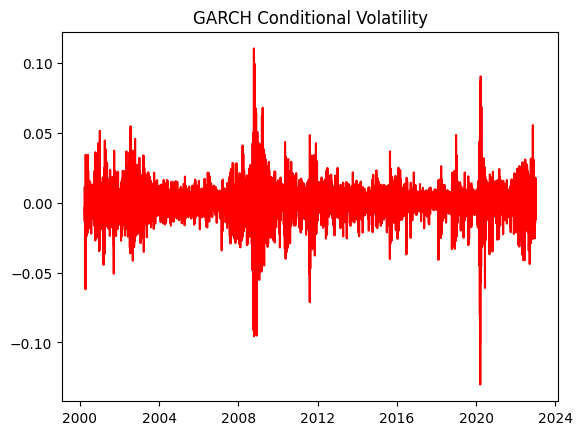

In [ ]:
plt.plot(raw_data['Log_Returns'], color='red')
plt.title('GARCH Conditional Volatility')

#Misc

In [ ]:
resp = requests.get('https://en.wikipedia.org/wiki/Russell_1000_Index#Components')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})


In [ ]:
tickers = []

for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[1].text
    tickers.append(ticker)


start_date = '2000-01-01'
end_date = '2022-12-31'

stock_data = {}

for tic in tickers:
    constituent_data = yf.download(tic, start=start_date, end=end_date)
    stock_data[tic] = constituent_data

# Example: Printing the first few rows of data for the first stock
print(stock_data[list(stock_data.keys())[0]].head())


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2019-09-12  54.000000  58.000000  51.000000  52.750000  52.750000  7326300
2019-09-13  52.750000  54.355000  49.150002  52.270000  52.270000  1025200
2019-09-16  52.450001  56.000000  52.009998  55.200001  55.200001   269900
2019-09-17  56.209999  60.900002  55.423000  56.779999  56.779999   602800
2019-09-18  56.849998  62.270000  55.650002  62.000000  62.000000  1589600


In [ ]:
stock_returns = {}

# Calculate daily returns for each constituent stock
for ticker, data in stock_data.items():
    # Calculate daily returns using percentage change
    returns = data['Adj Close'].pct_change()
    # Store the returns in the stock_returns dictionary
    stock_returns[ticker] = returns

# Example: Printing the first few rows of daily returns for the first stock
print(stock_returns)

{'TXG': Date
2019-09-12         NaN
2019-09-13   -0.009100
2019-09-16    0.056055
2019-09-17    0.028623
2019-09-18    0.091934
                ...   
2022-12-23   -0.061918
2022-12-27   -0.068633
2022-12-28   -0.006585
2022-12-29    0.156566
2022-12-30   -0.005459
Name: Adj Close, Length: 833, dtype: float64, 'MMM': Date
2000-01-03         NaN
2000-01-04   -0.039735
2000-01-05    0.028965
2000-01-06    0.080428
2000-01-07    0.019852
                ...   
2022-12-23   -0.011925
2022-12-27    0.000666
2022-12-28   -0.016054
2022-12-29    0.019275
2022-12-30   -0.005391
Name: Adj Close, Length: 5787, dtype: float64, 'ABT': Date
2000-01-03         NaN
2000-01-04   -0.028571
2000-01-05   -0.001839
2000-01-06    0.034991
2000-01-07    0.010676
                ...   
2022-12-23    0.001389
2022-12-27    0.003605
2022-12-28   -0.006816
2022-12-29    0.022999
2022-12-30   -0.004714
Name: Adj Close, Length: 5787, dtype: float64, 'ABBV': Date
2013-01-02         NaN
2013-01-03   -0.008258
2013-

In [ ]:
returns_df = pd.DataFrame(stock_returns)


In [ ]:
returns_df.dropna(how = 'all', axis = 1, inplace = True)
returns_df.interpolate(method = 'linear', axis = 1, inplace = True)
returns_df.fillna(value = 0, inplace = True)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')
returns_df.to_csv('/content/drive/My Drive/project2data.csv', index=True)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

data = pd.read_csv('/content/drive/MyDrive/project2data.csv')
data.set_index('Date', inplace = True)

#Sources:

https://www.mdpi.com/2078-2489/11/10/489

https://link.springer.com/article/10.1007/s10614-023-10373-8

https://medium.com/@ranjithkumar.rocking/time-series-model-s-arch-and-garch-2781a982b448

https://machinelearningmastery.com/develop-arch-and-garch-models-for-time-series-forecasting-in-python/

https://cs230.stanford.edu/projects_fall_2019/reports/26254244.pdf


https://github.com/tlemenestrel/LSTM_GARCH

OpenAI. (2023). ChatGPT (Mar 14 version) [Large language model]. https://chat.openai.com/chat

